In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
import ff
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


In [ ]:
np.random.seed(0)

In [ ]:
# some outputs were deleted to preserve anonymity

#  Read in Data

In [ ]:
# background
df = pd.read_csv('../../FFChallenge_v5/background.csv',index_col="challengeID")

In [ ]:
# metadata
metadata = pd.read_csv('../../FFMetadata_v13_UTF.csv')

/var/folders/5k/j3bfrd8s2_l092hd5snmdbzm0000gn/T/ipykernel_1068/4044725941.py:2: DtypeWarning: Columns (12,23,24,27,99,103,107,111,115,119,123,127,131,135,139,143,147,151) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('../../FFMetadata_v13_UTF.csv')


In [ ]:
train = pd.read_csv('../../FFChallenge_v5/train.csv')

In [ ]:
# convert negative values to nan
df = df.apply(pd.to_numeric, errors='coerce')
df[df < 0] = np.nan
# adopted from Rigobon et al., 2019

In [ ]:
# Remove columns with low variance or >70% missing values

num_rows = len(df)

drop_cols = []

processed_count = 0

for column in df.columns:
    try:
        processed_count += 1
        if processed_count % 1000 == 0:
            print(processed_count)
        
        if column == 'challengeID':
            continue

        unique_values = df[column].nunique()
        # get total missing values
        missing_values = df[column].isnull().sum()
        # check if col has low variance
        low_variance = df[column].std(skipna=True) < 0.05

        if unique_values == 1 or low_variance:
            drop_cols.append(column)

        # remove if >70% missing
        elif missing_values > num_rows * 0.7:
            drop_cols.append(column)
    except Exception as ex:
        print(f'Exception in column: {column}')
        print(ex)

df.drop(drop_cols, axis=1, inplace=True)

len(df.columns)
# adopted from Rigobon et al., 2019


1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


4508

In [ ]:
clean_data = df

# Impute Mean and Mode

In [ ]:
column_types = metadata.set_index('column_name')['type'].to_dict()

In [ ]:
counter = 1
cols_not_in_clean_data = 0
for column, col_type in column_types.items():
    if column in clean_data.columns:
        if col_type in ['Continuous', 'Ordered Categorical']:
            # Impute continuous and ordered categorical with mean
            clean_data[column].fillna(clean_data[column].mean(), inplace=True)
        elif col_type in ['Unordered Categorical', 'Binary']:
            try:
                # impute mode
                col_mode = mode(clean_data[column])
            except StatisticsError as e:
                print(e)
            clean_data[column].fillna(col_mode, inplace=True)
        else:
            # Drop any other columns
            clean_data.drop(column, axis=1, inplace=True)
            print(f"Column {column} dropped.")
    else:
        cols_not_in_clean_data += 1
        # print(f"Column {column} in metadata but not in clean_data.")
    counter += 1
    if counter % 1000 == 0:
        print(f'column {counter}')

print(clean_data.info())
print(f'cols not in clean: {cols_not_in_clean_data}')
clean_data.to_csv('../Output/mean_mode_imputed_70.csv', index=False)


column 1000
column 2000
column 3000
column 4000
column 5000
column 6000
column 7000
column 8000
column 9000
column 10000
column 11000
column 12000
Column ch5dspr dropped.
Column ch5ppvtpr dropped.
Column ch5wj9pr dropped.
Column ch5wj10pr dropped.
column 13000
column 14000
column 15000
column 16000
column 17000
column 18000
column 19000
column 20000
column 21000
column 22000
column 23000
column 24000
column 25000
column 26000
column 27000
column 28000
column 29000
column 30000
column 31000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4242 entries, 0 to 4241
Columns: 4505 entries, challengeID to k5f1
dtypes: float64(4487), int64(18)
memory usage: 145.8 MB
None
cols not in clean: 27426


In [3]:
imputed_df = pd.read_csv('../Output/mean_mode_imputed_70.csv')

# Drop Weight Columns and NAs

In [ ]:
weight_para_columns = metadata[metadata['topics'] == 'Paradata and weights']['new_name']

In [ ]:
# get weight_columns that exist in imputed_df
weight_para_columns = [col for col in weight_para_columns if col in imputed_df.columns]
weight_para_columns

['cf1lenhr',
 'cf1lenmin',
 'cf1fint',
 'cf1citsm',
 'f1citywt',
 'cf1tele',
 'f1citywt_rep1',
 'f1citywt_rep2',
 'f1citywt_rep3',
 'f1citywt_rep4',
 'f1citywt_rep5',
 'f1citywt_rep6',
 'f1citywt_rep7',
 'f1citywt_rep8',
 'f1citywt_rep9',
 'f1citywt_rep10',
 'cm1lenhr',
 'cm1lenmin',
 'cm1fint',
 'cm1citsm',
 'm1citywt',
 'cm1citysm',
 'm1citywt_rep1',
 'm1citywt_rep2',
 'm1citywt_rep3',
 'm1citywt_rep4',
 'm1citywt_rep5',
 'm1citywt_rep6',
 'm1citywt_rep7',
 'm1citywt_rep8',
 'm1citywt_rep9',
 'm1citywt_rep10',
 'cf2fint',
 'cf2mint',
 'cf2new12',
 'cf2samp',
 'cf2citsm',
 'f2citywt',
 'f2g4',
 'f2k1',
 'cf2tele',
 'f2citywt_rep1',
 'f2citywt_rep2',
 'f2citywt_rep3',
 'f2citywt_rep4',
 'f2citywt_rep5',
 'f2citywt_rep6',
 'f2citywt_rep7',
 'f2citywt_rep8',
 'f2citywt_rep9',
 'f2citywt_rep10',
 'cq2citsm',
 'q2citywt',
 'q2citywt_rep1',
 'q2citywt_rep2',
 'q2citywt_rep3',
 'q2citywt_rep4',
 'q2citywt_rep5',
 'q2citywt_rep6',
 'q2citywt_rep7',
 'q2citywt_rep8',
 'q2citywt_rep9',
 'q2city

In [ ]:
# drop weight_para_columns from imputed_df
imputed_df = imputed_df.drop(weight_para_columns, axis=1)

In [ ]:
imputed_df = imputed_df.apply(lambda x: x.astype(float) if x.dtype == 'int' else x)

In [ ]:
# check
na_percentage = imputed_df.isna().mean()
columns_with_more_than_70_na = na_percentage[na_percentage > 0.7].index.tolist()
if len(columns_with_more_than_70_na) > 0:
    print("Columns with more than 70% NAs:", columns_with_more_than_70_na)
else:
    print("No columns have more than 70% NAs.")

No columns have more than 70% NAs.


In [ ]:
# set metadata new_name column as string
metadata['new_name'] = metadata['new_name'].astype(str)

In [ ]:
# get list of metadata new_names
metadata_cols = metadata['new_name'].tolist()

In [6]:
imputed_df

,challengeID,f1a2,f1a3,f1a4,f1a5,f1a6,f1a6a,f1a7,cf1age,f1b1a,...,m4d6,m4d7,m4d9,m4e23,f4d6,f4d7,f4d9,m5d20,m5k10,k5f1
0,1.0,1.0,1.0,1.0,1.0,1.0,1.920735,1.0,27.92677,4.91459,...,2.351121,1.235117,6.269946,5.180325,2.511131,1.718804,6.473537,4.476881,9.628369,24.038266
1,2.0,2.0,1.0,1.0,1.0,1.0,4.000000,2.0,27.92677,1.00000,...,2.351121,1.235117,6.269946,27.680196,2.511131,1.718804,6.473537,26.671897,9.628369,3.667679
2,3.0,1.0,1.0,1.0,1.0,2.0,1.920735,102.0,24.00000,3.00000,...,2.351121,1.235117,6.269946,5.180325,20.867881,24.115867,6.473537,4.476881,9.628369,24.038266
3,4.0,1.0,1.0,1.0,1.0,2.0,1.920735,101.0,24.00000,3.00000,...,21.220233,23.172680,6.269946,5.180325,22.018875,22.932641,6.473537,4.476881,9.628369,4.140511
4,5.0,2.0,1.0,1.0,1.0,2.0,1.920735,1.0,19.00000,4.00000,...,21.386605,23.227584,6.269946,5.180325,22.916602,22.988036,6.473537,4.476881,9.628369,3.668879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4237,4238.0,1.0,1.0,1.0,1.0,1.0,1.920735,1.0,27.92677,4.91459,...,2.351121,1.235117,27.941956,5.180325,2.511131,1.718804,6.473537,4.476881,9.628369,24.038266
4238,4239.0,2.0,1.0,1.0,1.0,2.0,1.920735,101.0,24.00000,0.00000,...,2.351121,1.235117,28.703663,5.180325,2.511131,1.718804,6.473537,4.476881,9.628369,3.424922
4239,4240.0,1.0,1.0,1.0,1.0,1.0,1.920735,1.0,27.92677,4.91459,...,2.351121,1.235117,6.269946,26.990283,2.511131,1.718804,6.473537,4.476881,9.628369,24.038266
4240,4241.0,2.0,1.0,2.0,1.0,1.0,1.000000,2.0,29.00000,0.00000,...,2.351121,1.235117,6.269946,27.189692,2.511131,1.718804,28.512659,4.476881,9.628369,3.656543


# Filter Missing Outcome Data

In [ ]:
def get_filtered_data(x_df, train, outcome):
    ''' filters the X dataframe for outcome rows that are not NA
    params
    x_df: df of features
    train: df of outcomes
    outcome: column name of outcome variable'''
    imputed_df.reset_index(drop=True, inplace=True)
    train.reset_index(drop=True, inplace=True)

    # Merge features and outcomes on challenge ID
    merged_df = imputed_df.merge(train, on='challengeID', how='inner', suffixes=('_imp', '_train'))

    # Filter for outcome is not NA
    filtered_df = merged_df[merged_df[outcome].notna()]

    # get only x columns
    filtered_x_df = filtered_df[imputed_df.columns]
    
    # drop challengeid
    filtered_x_df = filtered_x_df.drop(columns=['challengeID'])
    
    # get only outcome column for y
    filtered_y_df = filtered_df[outcome]
    
    # drop challengeid
    filtered_y_df = filtered_y_df.drop(columns=['challengeID'])
    
    return filtered_x_df, filtered_y_df
    

In [ ]:
gpa_X, gpa_y = get_filtered_data(imputed_df, train, 'gpa')
grit_X, grit_y = get_filtered_data(imputed_df, train, 'grit')
MH_X, MH_y = get_filtered_data(imputed_df, train, 'materialHardship')
layoff_X, layoff_y = get_filtered_data(imputed_df, train, 'layoff')
eviction_X, eviction_y = get_filtered_data(imputed_df, train, 'eviction')
JT_X, JT_y = get_filtered_data(imputed_df, train, 'jobTraining')

In [ ]:
MH_y.describe()

count    1459.000000
mean        0.103745
std         0.155665
min         0.000000
25%         0.000000
50%         0.000000
75%         0.181818
max         0.818182
Name: materialHardship, dtype: float64

In [ ]:
len(MH_X)

1459

# Descriptive Statistics

In [ ]:
mh_describe_df = pd.DataFrame(MH_y.describe()).round(2)
pd.set_option('display.float_format', '{:.2f}'.format)

mh_describe_df

,materialHardship
count,1459.00
mean,0.10
std,0.16
min,0.00
25%,0.00
50%,0.00
75%,0.18
max,0.82


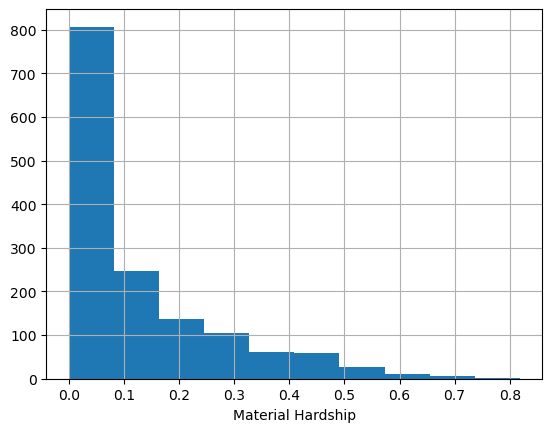

In [ ]:
MH_y.hist()

plt.xlabel('Material Hardship')

plt.show()


<Axes: >

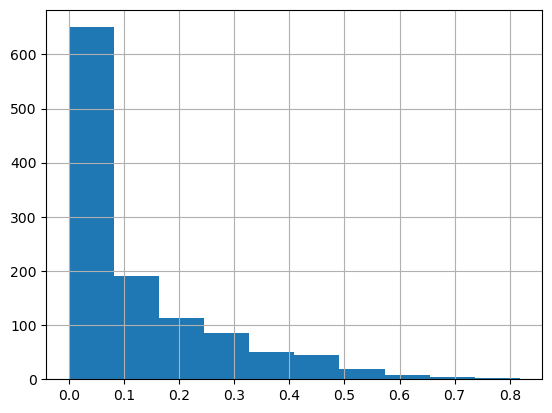

In [ ]:
MH_y_train.hist()

## Life Satisfaction

In [ ]:
og_data = pd.read_csv('../../FFChallenge_v5/background.csv')

/var/folders/5k/j3bfrd8s2_l092hd5snmdbzm0000gn/T/ipykernel_982/1403428012.py:1: DtypeWarning: Columns (5168,5272,5328,5329,5340,5341,5351,5470,5479,5661,5663,5685,5695,5696,5706,5764,5772,5788,5803,5815,5816,5828,5900,5901,5937,5946,5965,5966,9287,12349,12353,12356) have mixed types. Specify dtype option on import or set low_memory=False.
  og_data = pd.read_csv('../../FFChallenge_v5/background.csv')


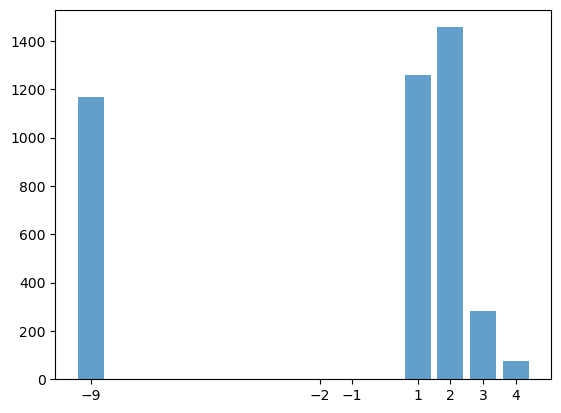

In [ ]:
# life satisfaction uncleaned data value counts
value_counts = og_data['m5g0'].value_counts()

plt.bar(value_counts.index, value_counts.values, color = 'C0', alpha = 0.7)

plt.xticks(value_counts.index)

plt.show()


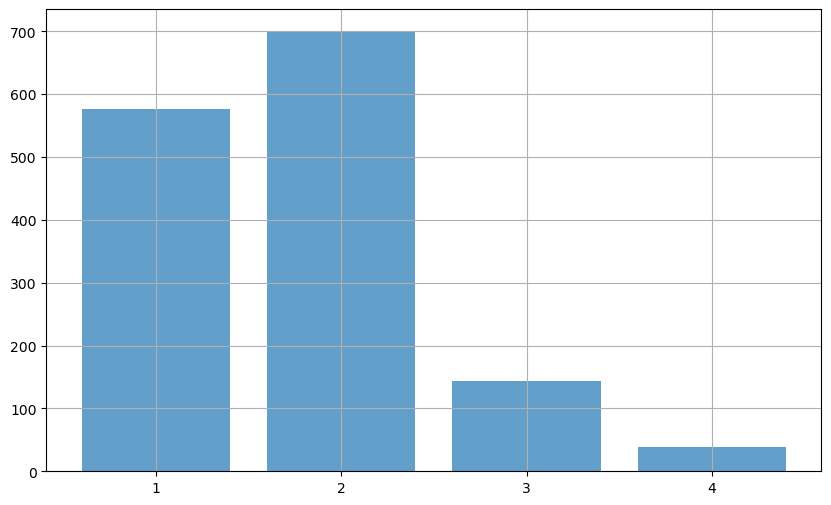

In [ ]:
# histogram of cleaned data
plt.figure(figsize=(10, 6))
# by bins from 1 to 4
counts, bins, patches = plt.hist(MH_X['m5g0'], bins=[0.5, 1.5, 2.5, 3.5, 4.5], alpha=0.7, rwidth = 0.8)
plt.xticks(ticks=np.add(bins[:-1], 0.5), labels=[1, 2, 3, 4])
plt.grid(True)
plt.show()


## Correlations

In [ ]:
satisfaction_vars = ['f3j0a', 'm3j0a', 'f4j0', 'm4j0', 'm5g0', 'f5g0']


In [ ]:
MH_X_satisfaction = MH_X[satisfaction_vars]

In [ ]:
satisfaction_correlations = MH_X_satisfaction.corrwith(MH_y)

In [ ]:
satisfaction_correlations

f3j0a   0.08
m3j0a   0.19
f4j0    0.07
m4j0    0.22
m5g0    0.26
f5g0    0.11
dtype: float64

In [ ]:
# map feature labels
label_mapping = {
    'm': 'Mother',
    'f': 'Father',
    '3': 'Year 3',
    '4': 'Year 5',
    '5': 'Year 9'
}

correlations_with_labels = correlations.rename(index=lambda x: ' '.join([label_mapping.get(char, char) for char in x[:2]]))

print(correlations_with_labels)

Father Year 3   0.08
Mother Year 3   0.19
Father Year 5   0.07
Mother Year 5   0.22
Mother Year 9   0.26
Father Year 9   0.11
dtype: float64


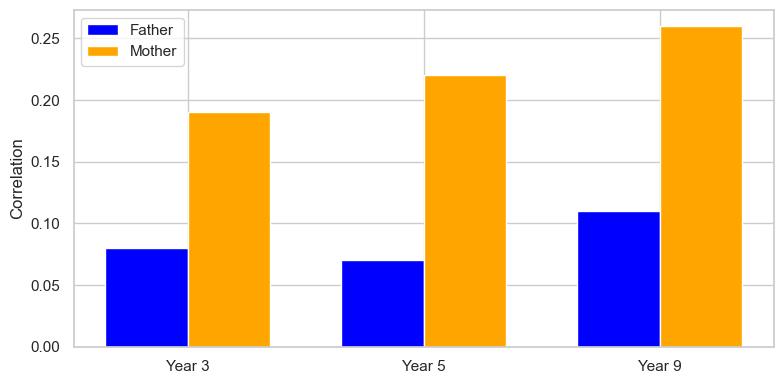

In [ ]:
# plot correlations
categories = ['Year 3', 'Year 5', 'Year 9']
father_correlation = [0.08, 0.07, 0.11]
mother_correlation = [0.19, 0.22, 0.26]

bar_width = 0.35
index = np.arange(len(categories))

plt.figure(figsize=(8, 4))
# plot father bars
bars1 = plt.bar(index, father_correlation, bar_width, label='Father', color='blue')
# plot mother bars
bars2 = plt.bar(index + bar_width, mother_correlation, bar_width, label='Mother', color='orange')

plt.ylabel('Correlation')
# add x ticks in middle of bars
plt.xticks(index + bar_width / 2, categories)
plt.legend()

plt.tight_layout()
plt.show()


# Get Train and Test

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def get_scaled_train_test(X, y, scale = True):
    # perform split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if scale == True:
        scaler = StandardScaler()
        scaler.fit(X_train)
        # fit only to training data
        X_train = scaler.transform(X_train)
        # apply to test
        X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test


In [ ]:
gpa_X_train, gpa_X_test, gpa_y_train, gpa_y_test = get_scaled_train_test(gpa_X, gpa_y, scale = False)
grit_X_train, grit_X_test, grit_y_train, grit_y_test = get_scaled_train_test(grit_X, grit_y, scale = False)
MH_X_train, MH_X_test, MH_y_train, MH_y_test = get_scaled_train_test(MH_X, MH_y, scale = False)
layoff_X_train, layoff_X_test, layoff_y_train, layoff_y_test = get_scaled_train_test(layoff_X, layoff_y, scale = False)
eviction_X_train, eviction_X_test, eviction_y_train, eviction_y_test = get_scaled_train_test(eviction_X, eviction_y, scale = False)
jobTraining_X_train, jobTraining_X_test, jobTraining_y_train, jobTraining_y_test = get_scaled_train_test(JT_X, JT_y, scale = False)

In [ ]:
len(MH_X_train)

1167

# Baseline Models

## Linear

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

In [ ]:
# dictionary to store MSEs
mh_mse_dict = defaultdict(dict)

In [ ]:
# material hardship
# pipeline: scale data, then apply linear regression model
mh_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# cross-validation: 5-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# run pipline with cv
mh_scores = cross_val_score(mh_pipeline, MH_X_train, MH_y_train, cv=kf, scoring='neg_mean_squared_error')
print("MSE mh_scores for each fold:", mh_scores)



MSE mh_scores for each fold: [-0.02512735 -0.02830853 -0.02628306 -0.02809355 -0.03055548]


In [ ]:
average_mse_mh = -np.mean(mh_scores)
print("Average MSE:", average_mse_mh)

Average MSE: 0.0276735928557441


In [ ]:
# Fit to training data and get test predictions
mh_pipeline.fit(MH_X_train, MH_y_train)

y_test_pred_mh = mh_pipeline.predict(MH_X_test)



In [ ]:
# MSE for test set
test_mse_mh = mean_squared_error(MH_y_test, y_test_pred_mh)
print("Test MSE:", test_mse_mh)


Test MSE: 0.030657293672143496


In [ ]:
# add to MSE dict
mse_dict['materialHardship'] = {'average_mse': average_mse_mh, 'test_mse': test_mse_mh}

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

In [ ]:
tree_model_MH = DecisionTreeRegressor(random_state=42)
tree_model_MH.fit(MH_X_train, MH_y_train)
MH_y_pred = tree_model_MH.predict(MH_X_test)
mse = mean_squared_error(MH_y_test, MH_y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.04437903317106308


In [ ]:
mse_scores = -cross_val_score(tree_model_MH, MH_X_train, MH_y_train, scoring='neg_mean_squared_error', cv=5)
mean_mse = mse_scores.mean()
print(f"Validation MSE for Decision Tree Regressor: {mean_mse:.4f}")


Validation MSE for Decision Tree Regressor: 0.0422


In [ ]:
mh_mse_dict['Decision Tree']['average_mse'] = mean_mse

In [ ]:
mh_mse_dict['Decision Tree']['test_mse'] = mse

## Lasso

In [ ]:
from sklearn.linear_model import LassoCV

# scale data and perform cross validation on 5 folds
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, random_state=42))
])

# Fit to training data
lasso_pipeline.fit(MH_X_train, MH_y_train)

# get lasso model
lasso_model = lasso_pipeline.named_steps['lasso']


In [ ]:
import pickle

# Save lasso_model
with open('lasso_model.pkl', 'wb') as file:
    pickle.dump(lasso_model, file)


In [ ]:
print("Best alpha:", lasso_model.alpha_)

Best alpha: 0.012179711046680858


In [ ]:
# Get best MSE from cross-validation
best_mse = np.min(lasso_mean_mse)
#0.019197434926763752

In [ ]:
# get test MSE
MH_y_pred = lasso_pipeline.predict(MH_X_test)
test_mse = mean_squared_error(MH_y_test, MH_y_pred)
print("Test MSE with Lasso-selected features:", test_mse)

Test MSE with Lasso-selected features: 0.02319955002439556


In [ ]:
mh_mse_dict = {'Linear': {'average_mse': average_mse_mh, 'test_mse': test_mse_mh}, 'Lasso': {'average_mse': best_mse, 'test_mse': test_mse}}


## Gradient Boosting

In [ ]:
from sklearn.model_selection import cross_val_score

gbm = GradientBoostingRegressor(random_state=42)
# cross validation + mse score
mse_scores = -cross_val_score(gbm, MH_X_train, MH_y_train, scoring='neg_mean_squared_error', cv=5)
mean_mse = mse_scores.mean()
print("Cross-Validation MSE for GBM:", mean_mse)

Cross-Validation MSE for GBM: 0.021562930163007997


In [ ]:
# fit and get test MSE
gbm.fit(MH_X_train, MH_y_train)
gbm_y_pred = gbm.predict(MH_X_test)
gbm_mse = mean_squared_error(MH_y_test, gbm_y_pred)
print(f'MSE for MH Prediction: {gbm_mse}')

MSE for MH Prediction: 0.024788991766004773


In [ ]:
mh_mse_dict['GBM'] = {'average_mse': mean_mse, 'test_mse': gbm_mse}

## XGBoost

In [ ]:
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np


Xall = MH_X.to_numpy()

parameters = {'n_estimators': [100, 1000],
                'learning_rate': [0.05, 0.02, 0.01],
                'max_depth': [2, 5],
                'subsample': [0.4, 0.6, 0.8],
                'colsample_bytree': [0.4, 0.6, 0.8]}

X = MH_X_train.to_numpy()
y = MH_y_train.to_numpy()

clf = GridSearchCV(XGBRegressor(),
                    parameters,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1, cv=5, verbose=0)
clf.fit(X, y)
print(clf.best_params_)

# adapted from Rigobon et al. (2019)

In [ ]:
best_model = clf.best_estimator_
y_pred_best = best_model.predict(MH_X_test)

# MSE on the test data
test_mse = mean_squared_error(MH_y_test, y_pred_best)
print("Test MSE:", test_mse)

Test MSE: 0.02385438702365414


In [ ]:
best_score = -clf.best_score_
print("Best Score:", best_score)

Best Score: 0.019368851412581763


In [ ]:
# add best_score and test_mse to mh_mse_dict
mh_mse_dict['XGBoost'] = {'average_mse': best_score, 'test_mse': test_mse}

## Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


In [ ]:
rf_model = RandomForestRegressor(n_estimators=100,  
                                 max_depth=None,    
                                 random_state=42,   
                                 n_jobs=-1)         


In [ ]:
rf_model.fit(MH_X_train, MH_y_train)


RandomForestRegressor(n_jobs=-1, random_state=42)

In [ ]:
rf_y_pred = rf_model.predict(MH_X_test)

rf_mse = mean_squared_error(MH_y_test, rf_y_pred)
print("Test MSE:", rf_mse)


Test MSE: 0.02386138061813654


In [ ]:
# cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, MH_X_train, MH_y_train, cv=kf, scoring='neg_mean_squared_error')
cv_mse = -cv_scores.mean() 
print("Average MSE from CV:", cv_mse)


Average MSE from CV: 0.019947013252062037


In [ ]:
mh_mse_dict['Random_Forest'] = {'average_mse': cv_mse, 'test_mse': rf_mse}


### Hyperparameter Search

In [ ]:
# Grid Search

# parameters for search
param_grid = {
    'n_estimators': [100, 200, 300], 
    'max_features': ['auto', 'sqrt', 'log2'], 
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4] 
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid, 
                           cv=5, 
                           n_jobs=-1, 
                           verbose=2,
                           scoring='neg_mean_squared_error')


In [ ]:
# run grid search
grid_search.fit(MH_X_train, MH_y_train)
print("Best parameters found by grid search:", grid_search.best_params_)


In [ ]:
# get MSE from grid search
grid_search_model = grid_search.best_estimator_  
cv_scores = cross_val_score(grid_search_model, MH_X_train, MH_y_train, cv=5, scoring='neg_mean_squared_error')
cv_mse = -cv_scores.mean()
print("Cross-Validation MSE for Grid Search Model:", cv_mse)


Cross-Validation MSE for Grid Search Model: 0.01994429646458638


In [ ]:
rf_y_pred = grid_search_model.predict(MH_X_test)
grid_mse = mean_squared_error(MH_y_test, rf_y_pred)
print("Test MSE:", rf_mse)

Test MSE: 0.02386138061813654


In [ ]:
# random search
from scipy.stats import randint as sp_randint

param_dist = {
    'n_estimators': sp_randint(100, 500),
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': sp_randint(2, 11),
    'min_samples_leaf': sp_randint(1, 5)
}

random_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=100, 
                                   cv=5,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1,
                                   scoring='neg_mean_squared_error')


In [ ]:
# run random search
random_search.fit(MH_X_train, MH_y_train)
print("Best parameters found by randomized search:", random_search.best_params_)


In [ ]:
random_search_model = random_search.best_estimator_


In [ ]:
random_y_pred = random_search_model.predict(MH_X_test)
random_mse = mean_squared_error(MH_y_test, random_y_pred)
print("Test MSE:", random_mse)

Test MSE: 0.023853081363909484


In [ ]:
mh_mse_dict['Random Forest Random Search']['average_mse'] = cv_mse
mh_mse_dict['Random Forest Random Search']['test_mse'] = random_mse

In [ ]:
from sklearn.ensemble import RandomForestClassifier
binary_random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=100,  # Number of parameter settings sampled
                                   cv=5,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1,
                                   scoring='neg_mean_squared_error')

### Feature Importance

In [ ]:
feature_importances = random_search_model.feature_importances_

feature_names = MH_X_train.columns

# get dict of feature name and importance
importance_dict = dict(zip(feature_names, feature_importances))

# sort by importance value
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# get top 50 features
top_features = 50 
for feature, importance in sorted_importance[:top_features]:
    print(f"{feature}: {importance}")


m5g0: 0.005216866885895575
m5f23g: 0.0050616714617254584
cm4hhinc: 0.003981660550161842
m5f23e: 0.003877079599710559
m5f23k: 0.003558159484848358
m4i23n: 0.003485048431213252
m4i23d: 0.003236301702752601
m5f23a: 0.002734628685586307
m4i23h: 0.002725563704983048
p4f1j: 0.0026967916409721265
m3i23d: 0.00269303194506965
ch3hap: 0.002684678578291538
m3j0a: 0.002658519494943027
cm3povco: 0.002612900070324364
m5f8a2: 0.0024587026679041613
m4i23l: 0.00230291483468533
m5j1: 0.00224775839017824
cm5povco: 0.002246537347951529
cf2hhincb: 0.0022412030069478266
m5f23c: 0.002171063611691921
p3l1: 0.002131306711502495
cf2hhinc: 0.002102887627781971
cf2povco: 0.002098826898465158
p3j7: 0.002030702701523001
m5g33: 0.0019983277275807073
m4j0: 0.0019876316069059037
cm2povco: 0.001800131850072561
m4l1: 0.0017804399240485863
p3a21: 0.0017732481192793813
cm4povco: 0.0017440811080693028
p4f1f: 0.001702376548492711
cm4povca: 0.001677520872303359
m2h9c2: 0.0016138235181065272
m1j2b: 0.0016041661812967365
p3j11

In [ ]:
# top rf features dict
rf_features_dict = {}
for feature, importance in sorted_importance[:top_features]:
    rf_features_dict[feature] = ff.select(feature,['focal_person','label','respondent','subtopics','topics','subtopics','survey','wave'])
    rf_features_dict[feature]['value'] = importance

In [ ]:
rf_features_df = pd.DataFrame(rf_features_dict).T

In [ ]:
rf_features_df

,focal_person,label,respondent,subtopics,survey,topics,wave,value
m5g0,Mother,G0. How satisfied you are with your life overall,Mother,attitudes/expectations/happiness,Mother,Attitudes and expectations,Year 9,0.005217
m5f23g,Mother,F23G. Borrowed money from friends/family to he...,Mother,material hardship ; private transfers,Mother,Finances,Year 9,0.005062
cm4hhinc,Mother,Constructed - Household income (with imputed v...,Mother,household income/poverty,Mother,Finances,Year 5,0.003982
m5f23e,Mother,F23E. Did not pay full amount of gas/oil/elect...,Mother,material hardship,Mother,Finances,Year 9,0.003877
m5f23k,Mother,F23K. Telephone service disconnected because w...,Mother,material hardship ; home environment,Mother,Finances ; Housing and neighborhood,Year 9,0.003558
m4i23n,Mother,"In past year, phone service disconnected b/c w...",Mother,material hardship ; home environment,Mother,Finances ; Housing and neighborhood,Year 5,0.003485
m4i23d,Mother,"In past year, did not pay full amt rent/mortga...",Mother,material hardship,Mother,Finances,Year 5,0.003236
m5f23a,Mother,F23A. Received free food or meals in past 12 m...,Mother,material hardship,Mother,Finances,Year 9,0.002735
m4i23h,Mother,"In past year, borrow money from friends or fam...",Mother,material hardship ; private transfers,Mother,Finances,Year 5,0.002726
p4f1j,Primary Caregiver,F1j. You are less interested in people than yo...,Primary Caregiver,parenting abilities,Primary Caregiver,Parenting,Year 5,0.002697


# LASSO Feature Selection

In [ ]:
coefficients = lasso_model.coef_

# get features with non-zero coeffs
for feature, coef in zip(MH_X_train.columns, coefficients):
    if coef != 0:
        print(f"{feature}: {coef}")

m1e3b5: 0.0011982133271067864
f2c14: 0.002010417472922448
f2j4: 0.0016172121775896837
cf2hhinc: -0.0009525032692881026
cf2povco: -0.0002573715511872814
m2h9a1: -0.00403304050243206
m2h10a: -3.3487446843877897e-17
f3k17c: 0.0003021961930993092
m3i7f: -0.0061328028517389785
m3i22: -0.0009770340874821685
m3i23d: -0.006475937531579534
m3i23e: -0.0064678314663823904
m3k21: -0.0008466853370096143
m3k25a: -0.0008369119927822161
m3k27a: -0.001709118490012428
p3a21: 0.0020037764081046413
p3d2: 0.004204652890002982
p3j7: 0.0035753321602266293
p3m17: 0.00029856566897655637
p3m31: 0.0011805987312055663
o3r1: 0.0025288065346244417
f4b6b: -0.0016573663439639749
f4b6c: -0.0007431662653272984
cf4povcab: -0.002694545468965038
m4i0a: -0.0021880000953080517
m4i14: 0.002993617754393844
m4i23d: -0.004913252140209718
m4i23n: -0.006849929390267173
m4j3: -0.0009850525965235638
cm4povca: -0.004500669500382357
p4d2: 0.0002864812565591847
p4f1e: -0.000313413548134778
p4f1f: -0.005394285853379161
p4g23d: 0.000190

In [ ]:
# get dict with features and metadata using ff api
lasso_features_dict = {}
for feature, coef in zip(MH_X_train.columns, coefficients):
    if coef != 0:
        lasso_features_dict[feature] = ff.select(feature,['focal_person','label','respondent','subtopics','topics','subtopics','survey','wave'])
        lasso_features_dict[feature]['coefficient'] = coef

In [ ]:
len(lasso_features_dict)

52

In [ ]:
# save dict
file_path = 'lasso_features_dict.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(lasso_features_dict, f)


In [ ]:
pd.DataFrame(lasso_features_dict)
# transpose
lasso_features_df = pd.DataFrame(lasso_features_dict).T

In [ ]:
lasso_features_df
# sort by coefficient absolute value
lasso_features_df = lasso_features_df.reindex(lasso_features_df['coefficient'].abs().sort_values(ascending=False).index)

In [ ]:
lasso_features_df.to_csv('../Output/Lasso_Features.csv')

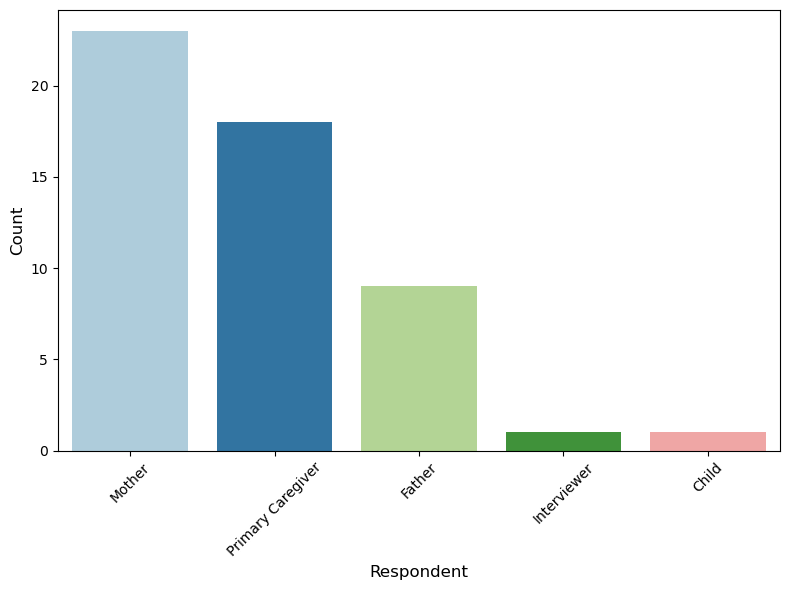

In [ ]:
# plot features by respondent

plt.figure(figsize=(8, 6))
ax = sns.countplot(x='respondent', data=lasso_features_df, palette='Paired')

plt.xlabel('Respondent', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()


Text(0, 0.5, 'Count')

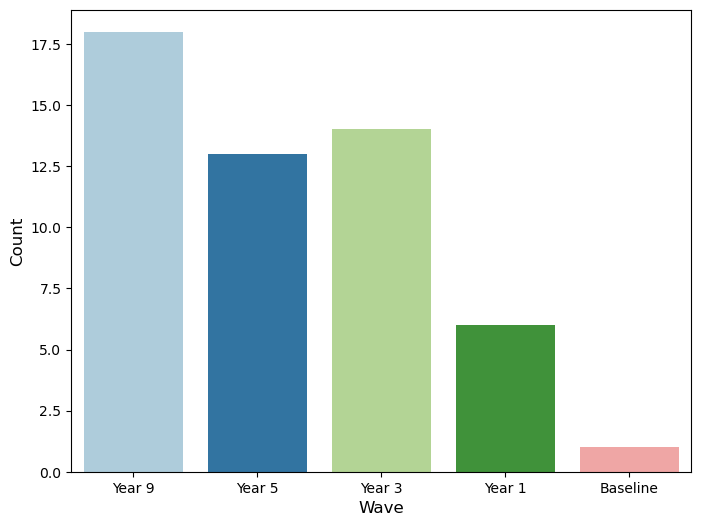

In [ ]:
# plot features by wave

plt.figure(figsize=(8, 6))
ax = sns.countplot(x='wave', data=lasso_features_df, palette='Paired')
plt.xlabel('Wave', fontsize=12)
plt.ylabel('Count', fontsize=12)


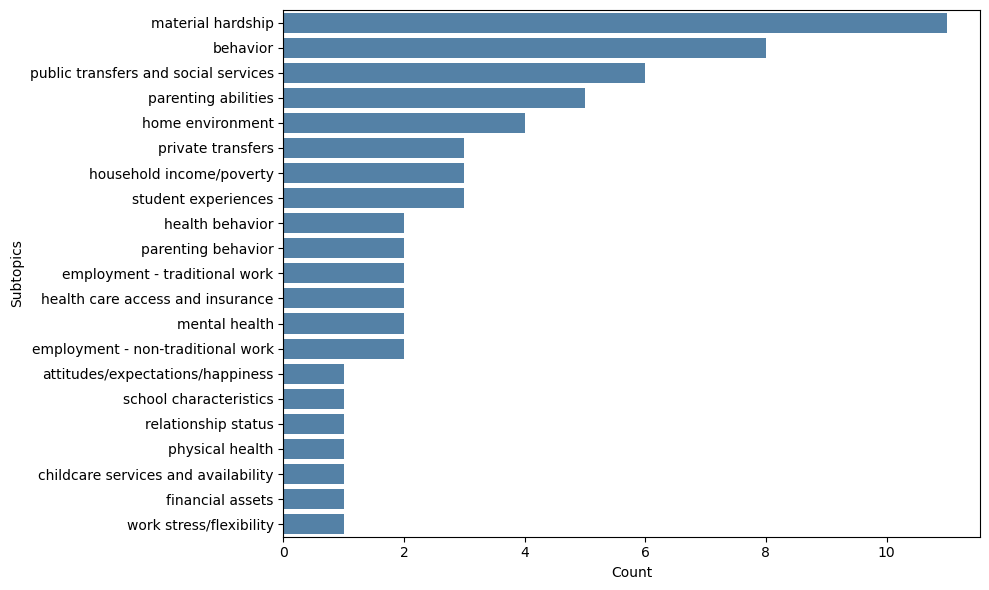

In [ ]:
#plot subtopics

# split multiple subtopics by semicolon
lasso_features_df['individual_subtopics'] = lasso_features_df['subtopics'].str.split(';')

# explode to individual row per subtopic
exploded_df = lasso_features_df.explode('individual_subtopics')
exploded_df['individual_subtopics'] = exploded_df['individual_subtopics'].str.strip()

bar_color = 'steelblue'

# plot horizontal bar chart by count
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=exploded_df, y='individual_subtopics', order=exploded_df['individual_subtopics'].value_counts().index, color = bar_color, orient='h')

plt.yticks(rotation=0)

plt.xlabel('Count')
plt.ylabel('Subtopics')

plt.tight_layout()

plt.show()

# Lasso on Selected Features

In [ ]:
# subset of MH_X_train with only features in lasso_features_dict
MH_X_train_lasso = MH_X_train[lasso_features_dict.keys()]
MH_X_test_lasso = MH_X_test[lasso_features_dict.keys()]


In [ ]:
# LASSO pipeline
lasso_pipeline_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, random_state=42))
])

lasso_pipeline_2.fit(MH_X_train_lasso, MH_y_train)

lasso_model_2 = lasso_pipeline_2.named_steps['lasso']


In [ ]:
print("Best alpha:", lasso_model_2.alpha_)

Best alpha: 0.0009213504747026076


In [ ]:
# CV MSE
lasso_mean_mse_2 = np.mean(lasso_model_2.mse_path_, axis=1)
best_mse = np.min(lasso_mean_mse_2)
print("Best MSE from Cross-Validation:", best_mse)

Best MSE from Cross-Validation: 0.016200801004051274


In [ ]:
MH_y_pred = lasso_pipeline_2.predict(MH_X_test_lasso)

# MSE on the test set
test_mse_lasso_2 = mean_squared_error(MH_y_test, MH_y_pred)
print("Test MSE with Lasso-selected features:", test_mse_lasso_2)


Test MSE with Lasso-selected features: 0.02511447660950494


In [ ]:
mh_mse_dict['Lasso_Features_Selected']['average_mse'] = best_mse

In [ ]:
mh_mse_dict['Lasso_Features_Selected']['test_mse'] = test_mse_lasso_2

# Random Forest on Selected Features

In [ ]:
random_search.fit(MH_X_train_lasso, MH_y_train)
print(f"Best parameters found by randomized search:", random_search.best_params_)
rf_lasso_model = random_search.best_estimator_
cv_scores = cross_val_score(rf_lasso_model, MH_X_train_lasso, MH_y_train, cv=5, scoring='neg_mean_squared_error')
cv_mse = -cv_scores.mean() 
mh_mse_dict['Random Forest LASSO Features']['average_mse'] = cv_mse
print("f{Outcome} Cross-Validation MSE for Random Search Model:", cv_mse)
random_y_pred = random_search_model.predict(MH_X_test_lasso)
random_mse = mean_squared_error(MH_y_test, random_y_pred)
mh_mse_dict['Random Forest LASSO Features']['test_mse'] = random_mse
print(f"{outcome} Test MSE:", random_mse)


In [ ]:
pd.DataFrame(mh_mse_dict)

,Linear,Lasso,Decision Tree,GBM,XGBoost,LASSO Selected Features,Random Forest
average_mse,0.027674,0.019197,0.042211,0.021563,0.019369,0.016201,0.019947
test_mse,0.030657,0.023200,0.044379,0.024789,0.023854,0.025114,0.023861


In [ ]:
mh_mse_dict['Random Forest LASSO Features']['average_mse'] = cv_mse
mh_mse_dict['Random Forest LASSO Features']['test_mse'] = random_mse


# Model Interpretation

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

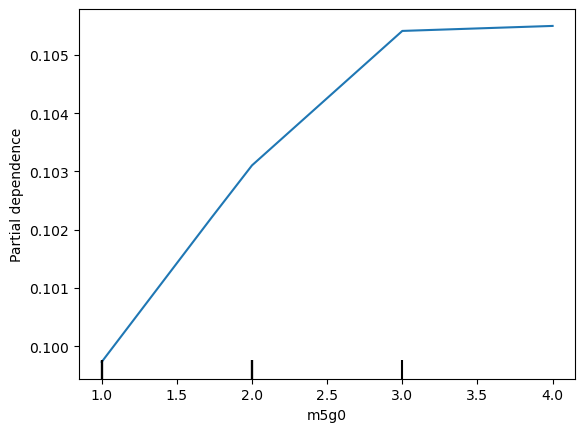

In [ ]:
features = ['m5g0']
PartialDependenceDisplay.from_estimator(random_search_model, MH_X_train, features)

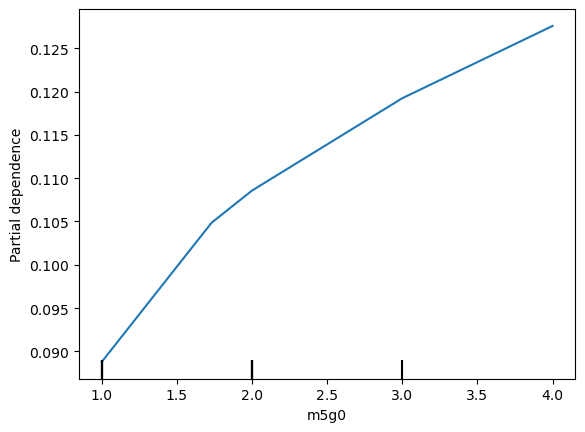

In [ ]:
PartialDependenceDisplay.from_estimator(rf_lasso_model, MH_X_train_lasso, features)

## SHAP

In [ ]:
# from week 2 notebook solutions
import shap
explainer = shap.TreeExplainer(rf_lasso_model)
shap_values = explainer.shap_values(MH_X_test_lasso)
shap.summary_plot(shap_values, MH_X_test_lasso, feature_names=MH_X_test_lasso.columns)

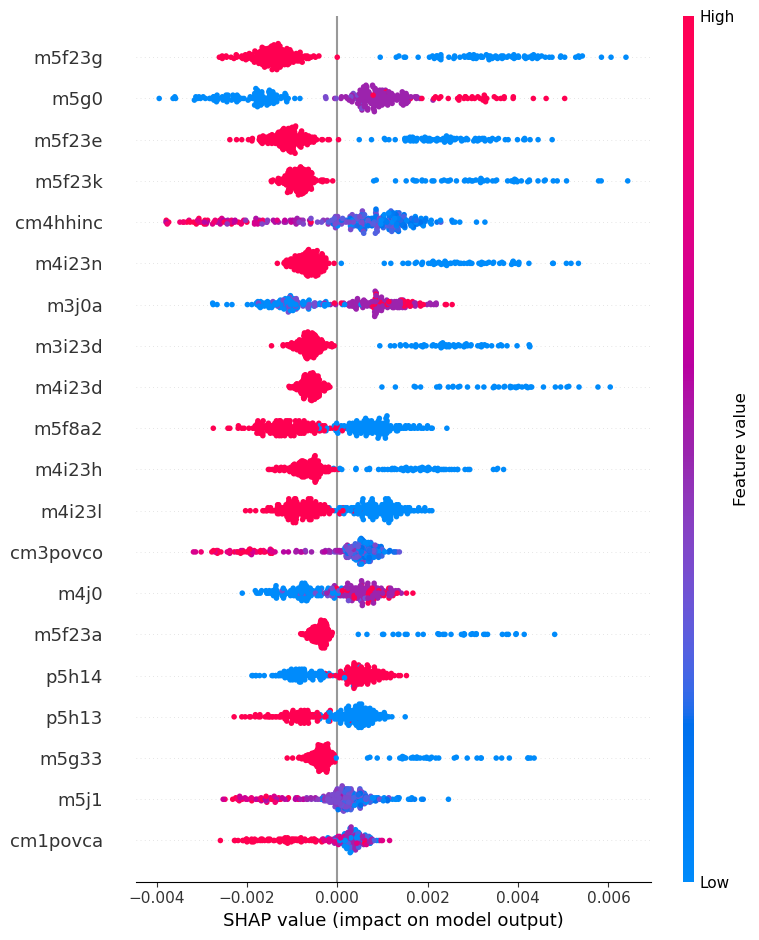

In [ ]:
# from week 2 notebook solutions
import shap
explainer_all = shap.TreeExplainer(random_search_model)
shap_values_all = explainer_all.shap_values(MH_X_test)
shap.summary_plot(shap_values_all, MH_X_test, feature_names=MH_X_test.columns)

# Models for Other 5 Outcomes

## Upsample Data

In [ ]:
gpa_datasets = [gpa_X_train, gpa_X_test, gpa_y_train, gpa_y_test]
grit_datasets = [grit_X_train, grit_X_test, grit_y_train, grit_y_test]
layoff_datasets = [layoff_X_train, layoff_X_test, layoff_y_train, layoff_y_test]
eviction_datasets = [eviction_X_train, eviction_X_test, eviction_y_train, eviction_y_test]
jobTraining_datasets = [jobTraining_X_train, jobTraining_X_test, jobTraining_y_train, jobTraining_y_test]
MH_datasets = [MH_X_train, MH_X_test, MH_y_train, MH_y_test]

In [ ]:
outcome_datasets = [gpa_datasets, grit_datasets, layoff_datasets, eviction_datasets, jobTraining_datasets, MH_datasets]


In [ ]:
outcomes = ['gpa', 'grit', 'eviction', 'jobTraining', 'layoff', 'materialHardship']


In [ ]:
def upsample(X_train, y_train):
    ''' get upsampled data for each binary class'''
    # get counts for each class
    unique_classes, counts = np.unique(y_train, return_counts=True)
    # get min and maj class
    minority_class = unique_classes[np.argmin(counts)]
    majority_class = unique_classes[np.argmax(counts)]
    # get mask for min and maj class
    minority_mask = y_train == minority_class
    majority_mask = y_train == majority_class
    # filter features for each class
    minority_features = X_train[minority_mask]
    majority_features = X_train[majority_mask]
    minority_labels = y_train[minority_mask]
    majority_labels = y_train[majority_mask]
    # get # of majority 
    n_majority = len(majority_features)
    # get indices for minority class
    ids = np.arange(len(minority_features))
    
    # upsampling
    choices = np.random.choice(ids, n_majority, replace=True)
    resampled_minority_features = minority_features.iloc[choices]
    resampled_minority_labels = minority_labels.iloc[choices]   
    # concat upsampled minority w/ majority
    resampled_features = pd.concat([resampled_minority_features, majority_features], axis=0)
    resampled_labels = pd.concat([resampled_minority_labels, majority_labels], axis=0)

    # shuffle
    order = np.random.permutation(len(resampled_labels))
    resampled_features = resampled_features.iloc[order].reset_index(drop=True)
    resampled_labels = resampled_labels.iloc[order].reset_index(drop=True)

    return resampled_features, resampled_labels

layoff_X_train_upsample, layoff_y_train_upsample = upsample(layoff_datasets[0], layoff_datasets[2])
eviction_X_train_upsample, eviction_y_train_upsample = upsample(eviction_datasets[0], eviction_datasets[2])
jobTraining_X_train_upsample, jobTraining_y_train_upsample = upsample(jobTraining_datasets[0], jobTraining_datasets[2])

# adapted from class tutorial 1 solutions

In [ ]:
# check class balance
def check_class_balance(y_train):
    unique_classes, counts = np.unique(y_train, return_counts=True)
    balance_info = dict(zip(unique_classes, counts))
    return balance_info

layoff_balance = check_class_balance(layoff_y_train_upsample)
eviction_balance = check_class_balance(eviction_y_train_upsample)
jobTraining_balance = check_class_balance(jobTraining_y_train_upsample)

print("Layoff dataset class balance:", layoff_balance)
print("Eviction dataset class balance:", eviction_balance)
print("Job Training dataset class balance:", jobTraining_balance)


Layoff dataset class balance: {0.0: 799, 1.0: 799}
Eviction dataset class balance: {0.0: 1095, 1.0: 1095}
Job Training dataset class balance: {0.0: 899, 1.0: 899}


In [ ]:
layoff_data_upsampled = [
    layoff_X_train_upsample,  # Upsampled training features
    layoff_datasets[1],       # Original testing features
    layoff_y_train_upsample,  # Upsampled training labels
    layoff_datasets[3]        # Original testing labels
]

eviction_data_upsampled = [
    eviction_X_train_upsample,  # Upsampled training features
    eviction_datasets[1],       # Original testing features
    eviction_y_train_upsample,  # Upsampled training labels
    eviction_datasets[3]        # Original testing labels
]

jobTraining_data_upsampled = [
    jobTraining_X_train_upsample,  # Upsampled training features
    jobTraining_datasets[1],       # Original testing features
    jobTraining_y_train_upsample,  # Upsampled training labels
    jobTraining_datasets[3]        # Original testing labels
]


In [ ]:
# update datasets
outcome_datasets = [gpa_datasets, grit_datasets, layoff_data_upsampled, eviction_data_upsampled, jobTraining_data_upsampled, MH_datasets]


In [ ]:
def model_outcomes_binary(outcome, dataset):
    X_train = dataset[0]
    X_test = dataset[1]
    y_train = dataset[2]
    y_test = dataset[3]
    print(f'{outcome} Model')
    mse_dict = defaultdict()
    if outcome in ['eviction','jobTraining','layoff']: 
        binary_random_search.fit(X_train, y_train)
        print(f"Best parameters found by randomized search:", binary_random_search.best_params_)
        random_search_model = binary_random_search.best_estimator_
    else:     
        random_search.fit(X_train, y_train)
        print(f"Best parameters found by randomized search:", random_search.best_params_)
        random_search_model = random_search.best_estimator_
        
    model_path = f'rf_{outcome}_model.joblib'
    # Save the model
    print(f"saving {outcome} model")
    joblib.dump(random_search_model, model_path)
    cv_scores = cross_val_score(random_search_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_mse = -cv_scores.mean()  
    mse_dict['cv_mse']: cv_mse
    print("f{Outcome} Cross-Validation MSE for Random Search Model:", cv_mse)
    random_y_pred = random_search_model.predict(X_test)
    test_mse = mean_squared_error(y_test, random_y_pred)
    mse_dict['test_mse']: test_mse
    print(f"{outcome} Test MSE:", test_mse)
    return cv_mse, test_mse

In [ ]:
binary_outcomes = ['layoff', 'eviction', 'jobTraining']
binary_datasets = [layoff_data_upsampled, eviction_data_upsampled, jobTraining_data_upsampled]

In [ ]:
binary_outcomes_performance_dict = defaultdict(dict)
for outcome, dataset in zip(binary_outcomes, binary_datasets):
    cv_mse, test_mse = model_outcomes_binary(outcome, dataset)
    binary_outcomes_performance_dict[outcome]['validation_mse'] = cv_mse
    binary_outcomes_performance_dict[outcome]['test_mse'] = test_mse


### With LASSO

In [ ]:
# get outcome features 
for outcome, dataset in zip(outcomes, outcome_datasets):
    X_train = dataset[0]
    X_test = dataset[1]
    y_train = dataset[2]
    y_test = dataset[3]
    
    print(f"{outcome} LASSO model")
    
    if outcome in ['eviction','jobTraining','layoff']: 
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic', LogisticRegressionCV(cv=5, penalty='l1', solver='saga', random_state=42))])
        model_name = 'logistic'
                
    else: 
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', LassoCV(cv=5, random_state=42))])
        model_name = 'lasso'

    print("fitting model")

    pipeline.fit(X_train, y_train)

    fitted_model = pipeline.named_steps[model_name]
    print("getting features")
    if model_name == 'logistic':
        coefficients = list(fitted_model.coef_[0])
    else:
        coefficients = fitted_model.coef_    

    for feature, coef in zip(X_train.columns, coefficients):
        if coef != 0:
            # lasso_features_dict_outcomes[outcome][feature] = ff.select(feature,['focal_person','label','respondent','subtopics','topics','subtopics','survey','wave'])
            lasso_features_dict_outcomes[outcome][feature] = coef

In [ ]:
outcome_X_data = defaultdict(dict)
for outcome, dataset in zip(outcomes, outcome_datasets): 
    X_train = dataset[0]
    X_test = dataset[1]
    y_train = dataset[2]
    y_test = dataset[3]
    # filter for lasso features
    outcome_X_train_lasso = X_train[lasso_features_dict_outcomes[outcome].keys()]
    outcome_X_test_lasso = X_test[lasso_features_dict_outcomes[outcome].keys()]
    outcome_X_data[outcome]['train'] = outcome_X_train_lasso
    outcome_X_data[outcome]['test'] = outcome_X_test_lasso
    

### Run Models

In [ ]:
def model_outcomes_lasso(outcome, dataset):
    # define data
    X_train = outcome_X_data[outcome]['train']
    X_test = outcome_X_data[outcome]['test']
    y_train = dataset[2]
    y_test = dataset[3]
    print(f'{outcome} Model')
    mse_dict = defaultdict()

    if outcome in ['eviction','jobTraining','layoff']: 
        binary_random_search.fit(X_train, y_train)
        print(f"Best parameters found by randomized search:", binary_random_search.best_params_)
        random_search_model = binary_random_search.best_estimator_
    else:     
        random_search.fit(X_train, y_train)
        print(f"Best parameters found by randomized search:", random_search.best_params_)
        random_search_model = random_search.best_estimator_
        
    model_path = f'rf_{outcome}_model.joblib'
    # save model
    joblib.dump(rf_model, model_path)
    # get scores
    cv_scores = cross_val_score(random_search_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_mse = -cv_scores.mean() 
    mse_dict['cv_mse']: cv_mse
    print("f{Outcome} Cross-Validation MSE for Random Search Model:", cv_mse)
    # get test score
    random_y_pred = random_search_model.predict(X_test)
    test_mse = mean_squared_error(y_test, random_y_pred)
    mse_dict['test_mse']: test_mse
    print(f"{outcome} Test MSE:", test_mse)
    return cv_mse, test_mse

In [ ]:
outcomes_performance_dict = defaultdict(dict)

In [ ]:
for outcome, dataset in zip(outcomes, outcome_datasets):
    cv_mse, test_mse = model_outcomes_lasso(outcome, dataset)
    outcomes_performance_dict[outcome]['validation_mse'] = cv_mse
    outcomes_performance_dict[outcome]['test_mse'] = test_mse


### Load Models and get Test CV

In [ ]:
layoff_model = joblib.load('rf_layoff_model.joblib')

In [ ]:
layoff_y_pred = eviction_model.predict(layoff_X_test)

In [ ]:
test_mse = mean_squared_error(layoff_y_test, layoff_y_pred)
test_mse

0.17578125

In [ ]:
eviction_model = joblib.load('rf_eviction_model.joblib')

In [ ]:
eviction_y_pred = eviction_model.predict(eviction_X_test)

In [ ]:
eviction_mse = mean_squared_error(eviction_y_test, eviction_y_pred)
eviction_mse

0.05136986301369863

In [ ]:
jt_model = joblib.load('rf_jobTraining_model.joblib')

In [ ]:
jt_y_pred = jt_model.predict(jobTraining_X_test)

In [ ]:
jt_mse = mean_squared_error(jobTraining_y_test, jt_y_pred)
jt_mse

0.24573378839590443

In [ ]:
pd.DataFrame(outcomes_performance_dict)

,gpa,jobTraining,eviction,grit,layoff
Test MSE,0.393647,0.049032,0.146754,0.239638,0.183421
